In [ ]:
import numpy as np

In [ ]:
import matplotlib.pyplot as plt

In [163]:
from tensorflow.keras.datasets import cifar10
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


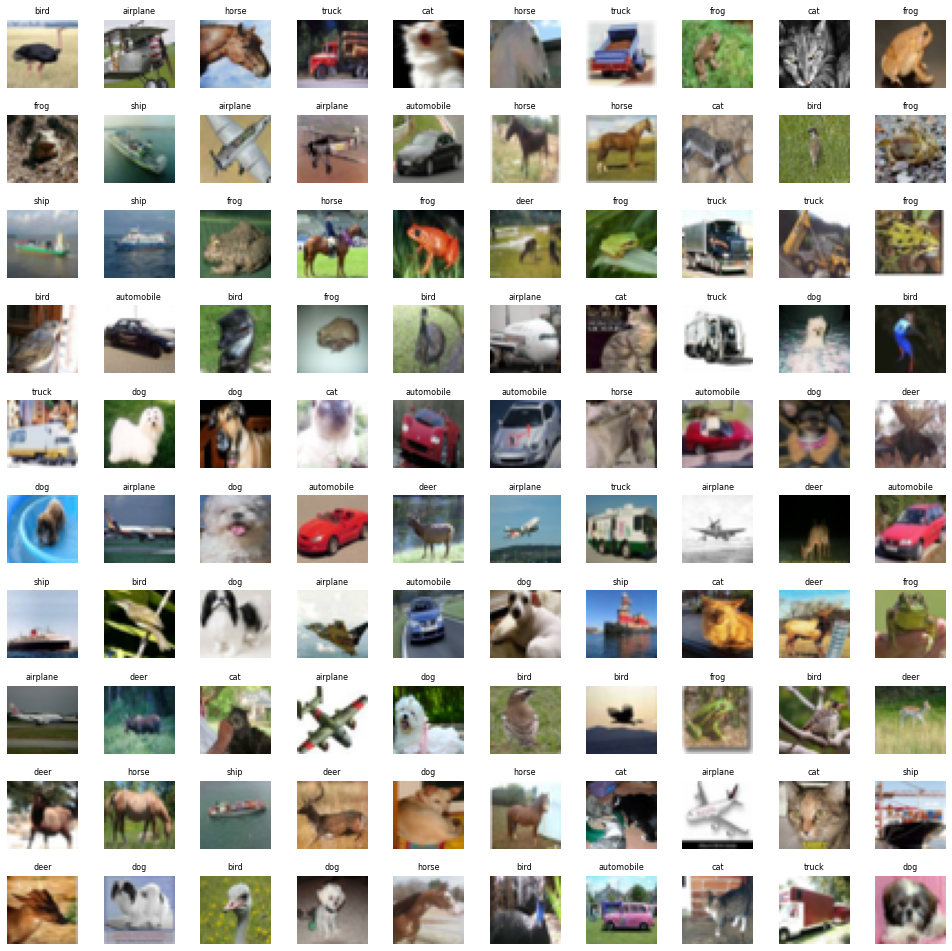

In [ ]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 10
L_grid = 10

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(X_train) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index    
    axes[i].imshow(X_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

Text(0.5, 1.0, 'Class distribution in training set')

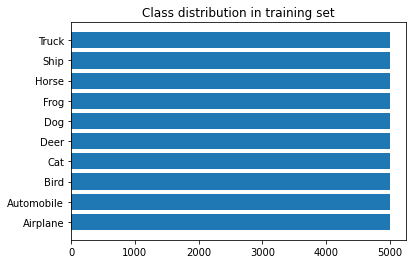

In [ ]:
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

classes, counts = np.unique(y_train, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in training set')

Text(0.5, 1.0, 'Class distribution in testing set')

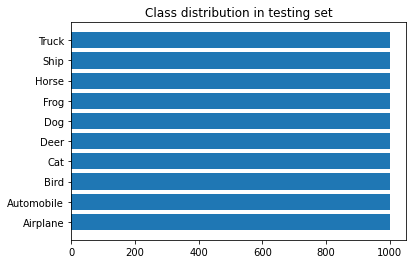

In [ ]:
classes, counts = np.unique(y_test, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in testing set')

In [ ]:
from tensorflow.keras.utils import to_categorical


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization

In [ ]:
from keras.applications.resnet import ResNet50


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# set GPU memory 
import keras
from keras import backend as K

In [ ]:
import keras
import argparse
import numpy as np
from keras.datasets import cifar10, cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, Dense, Input, add, Activation, GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler, TensorBoard, ModelCheckpoint
from keras.models import Model
from keras import optimizers, regularizers
from keras import backend as K



stack_n            = 5
layers             = 6 * stack_n + 2
num_classes        = 10
img_rows, img_cols = 32, 32
img_channels       = 3
batch_size         = 128
epochs             = 200
iterations         = 50000 // batch_size + 1
weight_decay       = 1e-4

def color_preprocessing(x_train,x_test):
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    mean = [125.307, 122.95, 113.865]
    std  = [62.9932, 62.0887, 66.7048]
    for i in range(3):
        x_train[:,:,:,i] = (x_train[:,:,:,i] - mean[i]) / std[i]
        x_test[:,:,:,i] = (x_test[:,:,:,i] - mean[i]) / std[i]
    return x_train, x_test


def scheduler(epoch):
    if epoch < 81:
        return 0.1
    if epoch < 122:
        return 0.01
    return 0.001


def residual_network(img_input,classes_num=10,stack_n=5):
    
    def residual_block(x,o_filters,increase=False):
        stride = (1,1)
        if increase:
            stride = (2,2)

        o1 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(x))
        conv_1 = Conv2D(o_filters,kernel_size=(3,3),strides=stride,padding='same',
                        kernel_initializer="he_normal",
                        kernel_regularizer=regularizers.l2(weight_decay))(o1)
        o2  = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(conv_1))
        conv_2 = Conv2D(o_filters,kernel_size=(3,3),strides=(1,1),padding='same',
                        kernel_initializer="he_normal",
                        kernel_regularizer=regularizers.l2(weight_decay))(o2)
        if increase:
            projection = Conv2D(o_filters,kernel_size=(1,1),strides=(2,2),padding='same',
                                kernel_initializer="he_normal",
                                kernel_regularizer=regularizers.l2(weight_decay))(o1)
            block = add([conv_2, projection])
        else:
            block = add([conv_2, x])
        return block

    # build model ( total layers = stack_n * 3 * 2 + 2 )
    # stack_n = 5 by default, total layers = 32
    # input: 32x32x3 output: 32x32x16
    x = Conv2D(filters=16,kernel_size=(3,3),strides=(1,1),padding='same',
               kernel_initializer="he_normal",
               kernel_regularizer=regularizers.l2(weight_decay))(img_input)

    # input: 32x32x16 output: 32x32x16
    for _ in range(stack_n):
        x = residual_block(x,16,False)

    # input: 32x32x16 output: 16x16x32
    x = residual_block(x,32,True)
    for _ in range(1,stack_n):
        x = residual_block(x,32,False)
    
    # input: 16x16x32 output: 8x8x64
    x = residual_block(x,64,True)
    for _ in range(1,stack_n):
        x = residual_block(x,64,False)

    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)

    # input: 64 output: 10
    x = Dense(classes_num,activation='softmax',kernel_initializer="he_normal",
              kernel_regularizer=regularizers.l2(weight_decay))(x)
    return x





print("========================================") 
print("MODEL: Residual Network ({:2d} layers)".format(6*stack_n+2)) 
print("BATCH SIZE: {:3d}".format(batch_size)) 
print("WEIGHT DECAY: {:.4f}".format(weight_decay))
print("EPOCHS: {:3d}".format(epochs))




MODEL: Residual Network (32 layers)
BATCH SIZE: 128
WEIGHT DECAY: 0.0001
EPOCHS: 200


In [ ]:
    global num_classes
    dataset = 'cifar10'
    if dataset == "cifar100":
        num_classes = 100
        (x_train, y_train), (x_test, y_test) = cifar100.load_data()
    else:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    

    print("== DONE! ==\n== COLOR PREPROCESSING... ==")
    # color preprocessing
    x_train, x_test = color_preprocessing(x_train, x_test)


    print("== DONE! ==\n== BUILD MODEL... ==")
    # build network
    img_input = Input(shape=(img_rows,img_cols,img_channels))
    output    = residual_network(img_input,num_classes,stack_n)
    resnet    = Model(img_input, output)
    
    # print model architecture if you need.
    # print(resnet.summary())


    # set optimizer
    sgd = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
    resnet.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    # set callback
    cbks = [TensorBoard(log_dir='./resnet_{:d}_{}/'.format(layers,dataset), histogram_freq=0),
            LearningRateScheduler(scheduler)]
    
    # dump checkpoint if you need.(add it to cbks)
    # ModelCheckpoint('./checkpoint-{epoch}.h5', save_best_only=False, mode='auto', period=10)

    # set data augmentation
    print("== USING REAL-TIME DATA AUGMENTATION, START TRAIN... ==")
    datagen = ImageDataGenerator(horizontal_flip=True,
                                 width_shift_range=0.125,
                                 height_shift_range=0.125,
                                 fill_mode='constant',cval=0.)

    datagen.fit(x_train)

    # start training
    resnet50_model = resnet.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                         steps_per_epoch=iterations,
                         epochs=125,
                         callbacks=cbks,
                         validation_data=(x_test, y_test))
    

== DONE! ==
== COLOR PREPROCESSING... ==
== DONE! ==
== BUILD MODEL... ==
== USING REAL-TIME DATA AUGMENTATION, START TRAIN... ==


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/125
391/391 [==============================] - 32s 74ms/step - loss: 1.9408 - accuracy: 0.3671 - val_loss: 1.7984 - val_accuracy: 0.4704
Epoch 2/125
391/391 [==============================] - 28s 71ms/step - loss: 1.3096 - accuracy: 0.6184 - val_loss: 1.4067 - val_accuracy: 0.6384
Epoch 3/125
391/391 [==============================] - 28s 70ms/step - loss: 1.0771 - accuracy: 0.7034 - val_loss: 1.2469 - val_accuracy: 0.6586
Epoch 4/125
391/391 [==============================] - 28s 71ms/step - loss: 0.9545 - accuracy: 0.7451 - val_loss: 1.5036 - val_accuracy: 0.6217
Epoch 5/125
391/391 [==============================] - 28s 70ms/step - loss: 0.8615 - accuracy: 0.7790 - val_loss: 1.0740 - val_accuracy: 0.7233
Epoch 6/125
391/391 [==============================] - 28s 71ms/step - loss: 0.8137 - accuracy: 0.7970 - val_loss: 0.9800 - val_accuracy: 0.7601
Epoch 7/125
391/391 [==============================] - 28s 71ms/step - loss: 0.7819 - accuracy: 0.8075 - val_loss: 0.8972 - val_ac

In [ ]:
predictions_test = np.argmax(resnet.predict(x_test), axis=1)
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
y =  np.argmax(y_test, axis=1)
print('Accuracy для тестового множества:', metrics.accuracy_score(y, predictions_test))
print('Precision для тестового множества:', metrics.precision_score(y, predictions_test, average='macro'))
print('Recall для тестового множества:', metrics.recall_score(y, predictions_test, average='macro'))
print('F1-measure для тестового множества:', metrics.f1_score(y, predictions_test, average='macro'))

Accuracy для тестового множества: 0.9217
Precision для тестового множества: 0.9217414615500671
Recall для тестового множества: 0.9216999999999999
F1-measure для тестового множества: 0.9216465777214442


In [ ]:
resnet50_model.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [ ]:
resnet50_model.model.save('resnet_{:d}_{}.h5'.format(layers,dataset))

In [188]:
resnet50_model = keras.models.load_model("/content/resnet_32_cifar10 (1).h5")

In [189]:
resnet50_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_132 (Conv2D)             (None, 32, 32, 16)   448         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_124 (BatchN (None, 32, 32, 16)   64          conv2d_132[0][0]                 
__________________________________________________________________________________________________
activation_124 (Activation)     (None, 32, 32, 16)   0           batch_normalization_124[0][0]    
____________________________________________________________________________________________

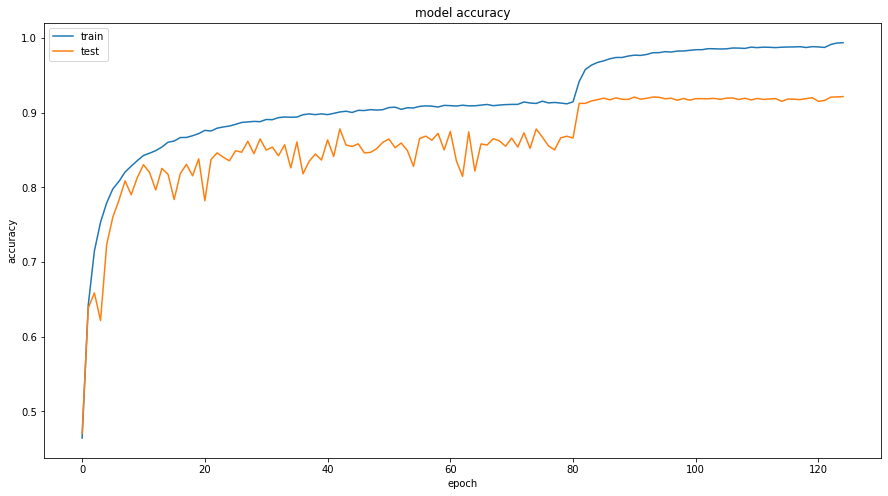

In [ ]:
plt.figure(figsize = (15,8)) 

plt.plot(resnet50_model.history['accuracy'])  
plt.plot(resnet50_model.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test']) 
    

plt.show()

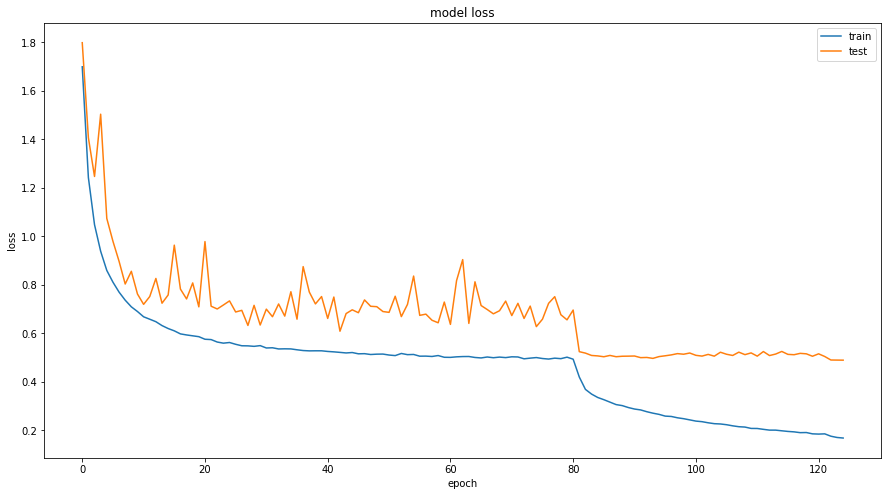

In [ ]:
plt.figure(figsize = (15,8)) 

plt.plot(resnet50_model.history['loss'])  
plt.plot(resnet50_model.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test']) 
    

plt.show()

Матрица ошибок для тестового множества:
 [[930   4  16   9   0   0   1   1  31   8]
 [  0 970   1   1   1   0   1   1   6  19]
 [ 26   0 893  24  16  15  17   5   2   2]
 [ 15   3  21 830  20  74  23  10   3   1]
 [  4   1  19  17 926   9  11  12   1   0]
 [  7   0  17  67  13 882   4   8   2   0]
 [  6   1  13  19   3   4 951   1   1   1]
 [  8   0   8  12  18  23   1 928   1   1]
 [ 23   4   4   2   0   1   0   3 960   3]
 [ 12  28   0   2   0   0   0   0  11 947]]


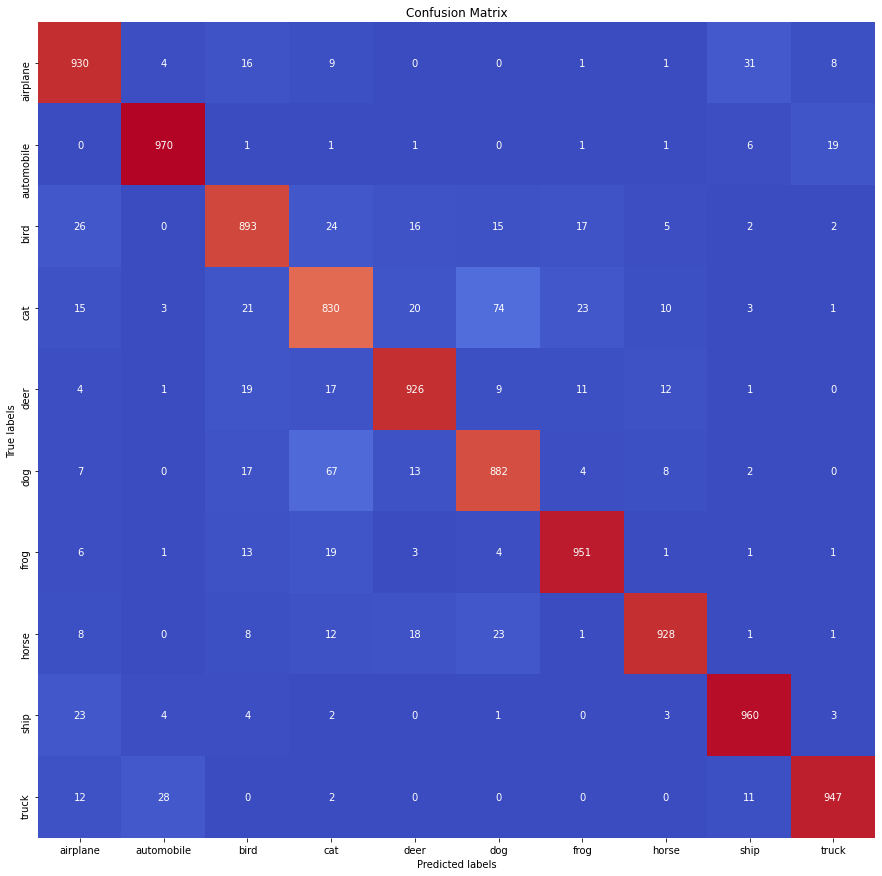

In [ ]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']
y_ = [labels[i] for i in y]
a_ = [labels[i] for i in predictions_test]
cm = confusion_matrix(y_, a_)
print("Матрица ошибок для тестового множества:\n", cm)

plt.figure(figsize=(15, 15))
ax= plt.subplot()

sns.heatmap(cm, cbar=False, fmt='d', annot=True, cmap=plt.cm.coolwarm); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

In [ ]:
resnet50_model.model.predict()

In [173]:
x_train.shape

(2500, 32, 32, 3)

In [174]:
    y_train = keras.utils.to_categorical(Y_train, 10)
    y_test = keras.utils.to_categorical(Y_test, 10)
    

    print("== DONE! ==\n== COLOR PREPROCESSING... ==")
    # color preprocessing
    x_train, x_test = color_preprocessing(X_train, X_test)



== DONE! ==
== COLOR PREPROCESSING... ==


In [176]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
resnet.predict()

In [190]:
predictions_test = np.argmax(resnet50_model.predict(x_train), axis=1)
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
y =  np.argmax(y_train, axis=1)  
print('Accuracy для обучающего множества:', metrics.accuracy_score(y, predictions_test))
print('Precision для обучающего множества:', metrics.precision_score(y, predictions_test, average='macro'))
print('Recall для обучающего множества:', metrics.recall_score(y, predictions_test, average='macro'))
print('F1-measure для обучающего множества:', metrics.f1_score(y, predictions_test, average='macro'))

Accuracy для обучающего множества: 0.99372
Precision для обучающего множества: 0.9937244082714457
Recall для обучающего множества: 0.99372
F1-measure для обучающего множества: 0.9937203805905701


Матрица ошибок для тестового множества:
 [[4982    2    6    1    0    0    1    1    7    0]
 [   0 4995    0    1    0    0    0    0    0    4]
 [  15    2 4952   12    6    4    7    0    1    1]
 [   6    1   12 4930    4   33    7    1    2    4]
 [   0    0    6   13 4959    8   11    2    0    1]
 [   1    0    6   35    4 4949    2    3    0    0]
 [   0    0    9    5    1    4 4980    0    1    0]
 [   1    2    2    2    4   14    0 4974    1    0]
 [  11    1    0    0    0    0    0    0 4986    2]
 [   2   15    0    1    0    0    0    0    3 4979]]


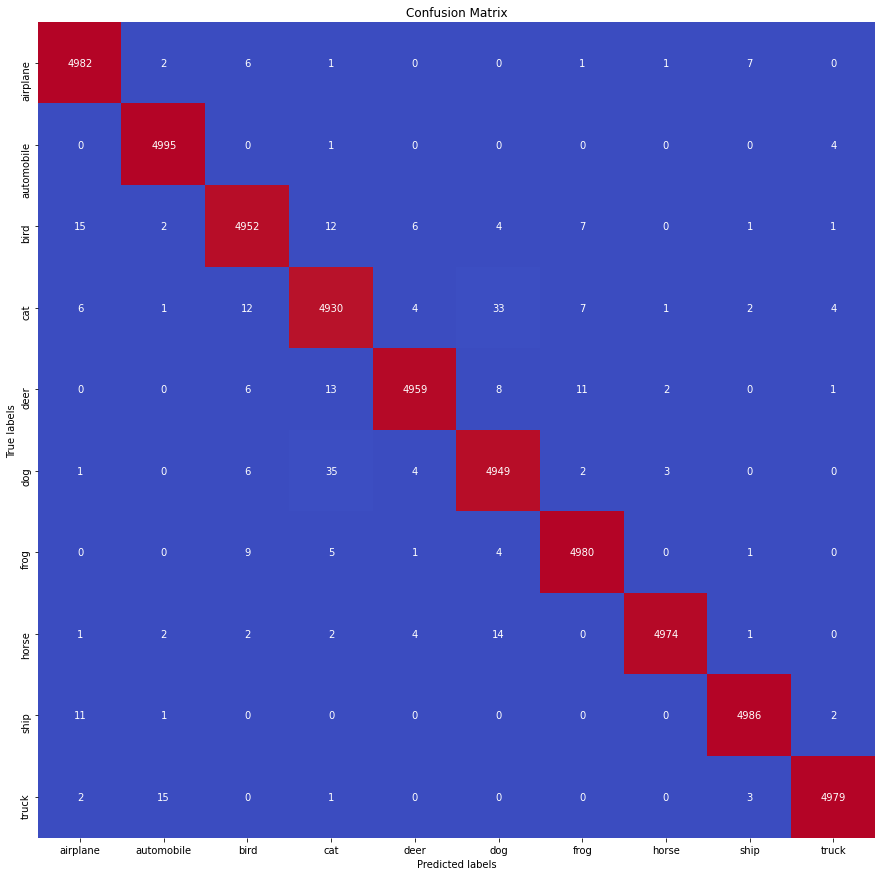

In [191]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']
y_ = [labels[i] for i in y]
a_ = [labels[i] for i in predictions_test]
cm = confusion_matrix(y_, a_)
print("Матрица ошибок для тестового множества:\n", cm)

plt.figure(figsize=(15, 15))
ax= plt.subplot()

sns.heatmap(cm, cbar=False, fmt='d', annot=True, cmap=plt.cm.coolwarm); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

In [ ]:
x = resnet50_model.layers[-2].output
x = Dense(15, activation='softmax', kernel_initializer="he_normal",
              kernel_regularizer=regularizers.l2(weight_decay))(x)

new_model = Model(resnet50_model.input, x)

In [ ]:
resnet50_model.model.summary()

In [ ]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_132 (Conv2D)             (None, 32, 32, 16)   448         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_124 (BatchN (None, 32, 32, 16)   64          conv2d_132[0][0]                 
__________________________________________________________________________________________________
activation_124 (Activation)     (None, 32, 32, 16)   0           batch_normalization_124[0][0]    
______________________________________________________________________________________________

In [ ]:
resnet50_model.model.save_weights('model_w.h5')

In [ ]:
for m in new_model.layers:
  m.trainable = False
m = new_model.layers[-1]
m.trainable = True

In [ ]:
from tensorflow.keras.datasets import cifar100
(x100_train, y100_train), (x100_test, y100_test) = cifar100.load_data(label_mode='coarse')
(x100_train_, y100_train_), (x100_test_, y100_test_) = cifar100.load_data(label_mode='fine')

In [ ]:
a = np.ndarray(shape=(2500,1))
a1 = np.ndarray(shape=(500,1))

In [ ]:
df = pd.DataFrame(y100_train)
df1 = pd.DataFrame(y100_test)

In [ ]:
m = df[df[0] == 15]
m1 = df1[df1[0] == 15]

In [ ]:
w = np.ndarray(shape=(2500,32,32,3),dtype='uint8')
w1 = np.ndarray(shape=(500,32,32,3),dtype='uint8')

In [ ]:
j = 0
for i in m.index:
  w[j]=x100_train[i]
  a[j] = y100_train_[i]
  j += 1
j = 0
for i in m1.index:
  w1[j]=x100_test[i]
  a1[j] = y100_test_[i]
  j += 1

In [ ]:
# 15: [29, 93, 27, 78, 44]
b = a.copy()
for i in range(len(a)):
  if a[i] == 29:
    b[i] = 10
  if a[i] == 93:
    b[i] = 11
  if a[i] == 27:
    b[i] = 12
  if a[i] == 78:
    b[i] = 13
  if a[i] == 44:
    b[i] = 14
x_train, y_train = w,b

b1 = a1.copy()
for i in range(len(a1)):
  if a1[i] == 29:
    b1[i] = 10
  if a1[i] == 93:
    b1[i] = 11
  if a1[i] == 27:
    b1[i] = 12
  if a1[i] == 78:
    b1[i] = 13
  if a1[i] == 44:
    b1[i] = 14
x_test, y_test = w1,b1

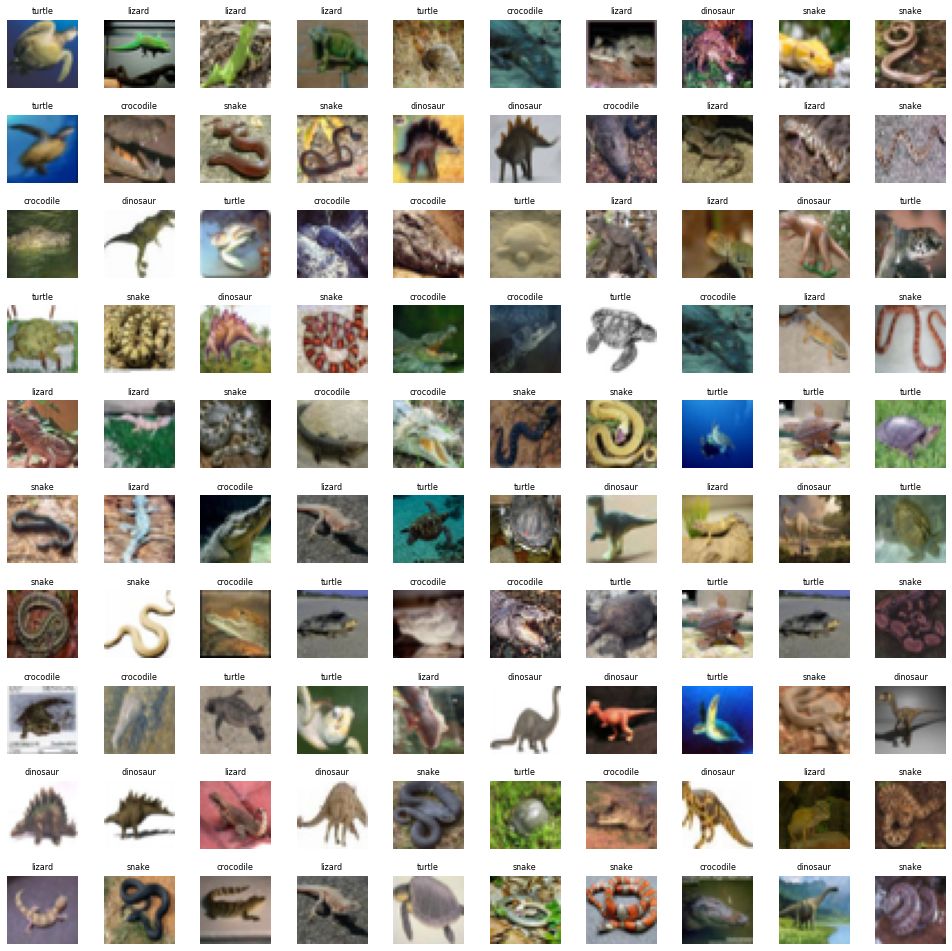

In [ ]:

W_grid = 10
L_grid = 10
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck',	'dinosaur', 'turtle', 'crocodile', 'snake', 'lizard']
fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(x_train) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index    
    axes[i].imshow(x_train[index,1:].astype('uint8'))
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [ ]:
x_train15 = np.concatenate((X_train, x_train))
x_test15 = np.concatenate((X_test, x_test))
y_train15 = np.concatenate((Y_train, y_train))
y_test15 = np.concatenate((Y_test, y_test))

In [ ]:
y_train15.shape

(52500, 1)

In [ ]:
y_test15.shape

(10500, 1)

In [ ]:
x_train15.shape

(52500, 32, 32, 3)

In [ ]:
x_test15.shape

(10500, 32, 32, 3)

In [ ]:



y_train_ = keras.utils.to_categorical(y_train15, 15)
y_test_ = keras.utils.to_categorical(y_test15, 15)
        

print("== DONE! ==\n== COLOR PREPROCESSING... ==")
    # color preprocessing
x_train_, x_test_ = color_preprocessing(x_train15, x_test15)


print("== DONE! ==\n== BUILD MODEL... ==")
    # build network
new_model.compile()
    
    # print model architecture if you need.
    # print(resnet.summary())
sgd = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
new_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# set callback
cbks = [TensorBoard(log_dir='./resnet_{:d}_{}/'.format(layers,'cifar100'), histogram_freq=0),
            LearningRateScheduler(scheduler)]
    
    # set data augmentation
print("== USING REAL-TIME DATA AUGMENTATION, START TRAIN... ==")
datagen = ImageDataGenerator(horizontal_flip=True,
                                 width_shift_range=0.125,
                                 height_shift_range=0.125,
                                 fill_mode='constant',cval=0.)
datagen.fit(x_train_)

    # start training
resnet50_model = new_model.fit_generator(datagen.flow(x_train_, y_train_,batch_size=batch_size),
                         steps_per_epoch=iterations,
                         epochs=5,
                         callbacks=cbks,
                         validation_data=(x_test_, y_test_))

== DONE! ==
== COLOR PREPROCESSING... ==
== DONE! ==
== BUILD MODEL... ==
== USING REAL-TIME DATA AUGMENTATION, START TRAIN... ==


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
391/391 [==============================] - 251s 633ms/step - loss: 0.3095 - accuracy: 0.9533 - val_loss: 0.6634 - val_accuracy: 0.8756
Epoch 2/5
391/391 [==============================] - 249s 636ms/step - loss: 0.3067 - accuracy: 0.9551 - val_loss: 0.6624 - val_accuracy: 0.8753
Epoch 3/5
391/391 [==============================] - 248s 635ms/step - loss: 0.3038 - accuracy: 0.9557 - val_loss: 0.6638 - val_accuracy: 0.8785
Epoch 4/5
391/391 [==============================] - 250s 639ms/step - loss: 0.3060 - accuracy: 0.9570 - val_loss: 0.6589 - val_accuracy: 0.8784
Epoch 5/5
391/391 [==============================] - 251s 643ms/step - loss: 0.3091 - accuracy: 0.9564 - val_loss: 0.6621 - val_accuracy: 0.8771


In [193]:

plt.figure(figsize = (15,8)) 

plt.plot(resnet50_model.history['accuracy'])  
plt.plot(resnet50_model.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test']) 
    

plt.show()

TypeError: ignored

<Figure size 1080x576 with 0 Axes>

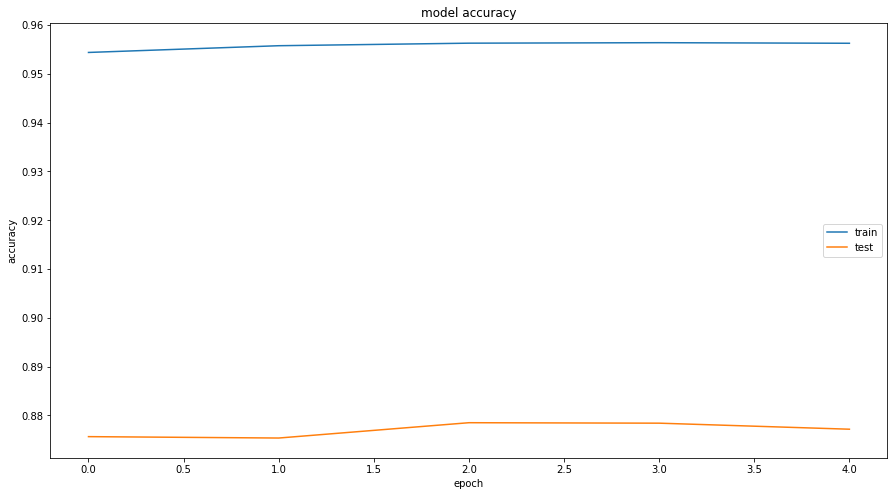

In [ ]:
plt.figure(figsize = (15,8)) 

plt.plot(resnet50_model.history['accuracy'])  
plt.plot(resnet50_model.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test']) 
    

plt.show()

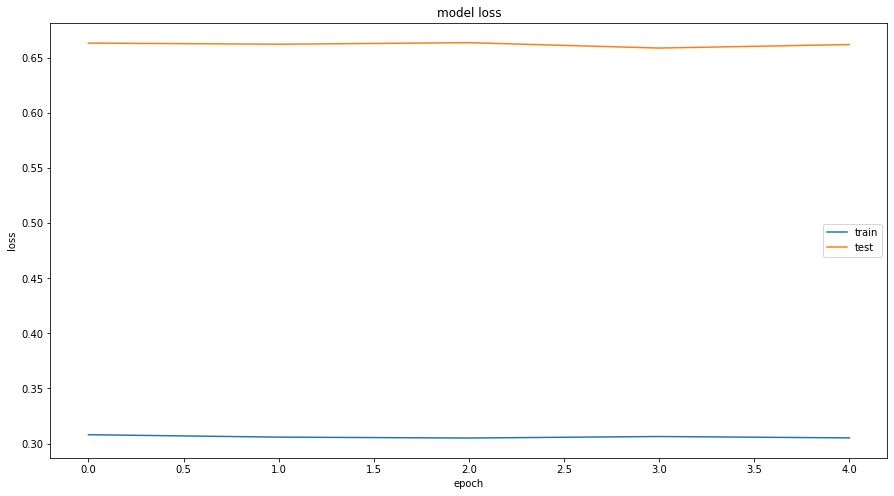

In [ ]:
plt.figure(figsize = (15,8)) 

plt.plot(resnet50_model.history['loss'])  
plt.plot(resnet50_model.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test']) 
    

plt.show()

In [ ]:
predictions_test = np.argmax(new_model.predict(x_test_), axis=1)
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
y =  np.argmax(y_test_, axis=1)
print('Accuracy для тестового множества:', metrics.accuracy_score(y, predictions_test))
print('Precision для тестового множества:', metrics.precision_score(y, predictions_test, average='macro'))
print('Recall для тестового множества:', metrics.recall_score(y, predictions_test, average='macro'))
print('F1-measure для тестового множества:', metrics.f1_score(y, predictions_test, average='macro'))

Accuracy для тестового множества: 0.8771428571428571
Precision для тестового множества: 0.6998914318885617
Recall для тестового множества: 0.6992
F1-measure для тестового множества: 0.696674344889203


In [ ]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck',	'dinosaur', 'turtle', 'crocodile', 'snake', 'lizard']
y_ = [labels[i] for i in y]
a_ = [labels[i] for i in predictions_test]

In [ ]:
y_test_.shape

(10500, 15)

Матрица ошибок для тестового множества:
 [[929   3  11   4  14   1   2   0   0   1   3  23   1   6   2]
 [  6 963   1   0   0   1   1   0   0   0   0   6   3  19   0]
 [ 29   0 853  20  16  12   9  13  10   3   6   2  19   2   6]
 [ 12   3  12 820  12  14   9  66  16   7   3   2  16   1   7]
 [  8   0   6  13  39   2   0   1  16   1   7   1   1   0   5]
 [  4   1  12  16   7 917  16   7   6   5   3   1   4   0   1]
 [  8   0  15  10   4   5  29   2   7   2   5   3   5   1   4]
 [  8   0  10  76   3  14   3 849   4   6   2   1  19   0   5]
 [  4   1   7  13  12   0   2   1 927   1   9   0  15   1   7]
 [  9   0   6  19   0  18  10  23   0 912   1   1   0   1   0]
 [ 14   0   8   9  11   5   3   4  23   1   8   1   6   1   6]
 [ 28   3   3   2   3   0   1   1   0   0   0 954   2   3   0]
 [  5   2  11   2   7   3   2   4  21   1   0   1  38   0   3]
 [ 13  25   0   3   0   0   1   0   0   1   0  13   0 944   0]
 [ 13   0  10  15   4   3   0   0  11   0   2   0  14   0  28]]


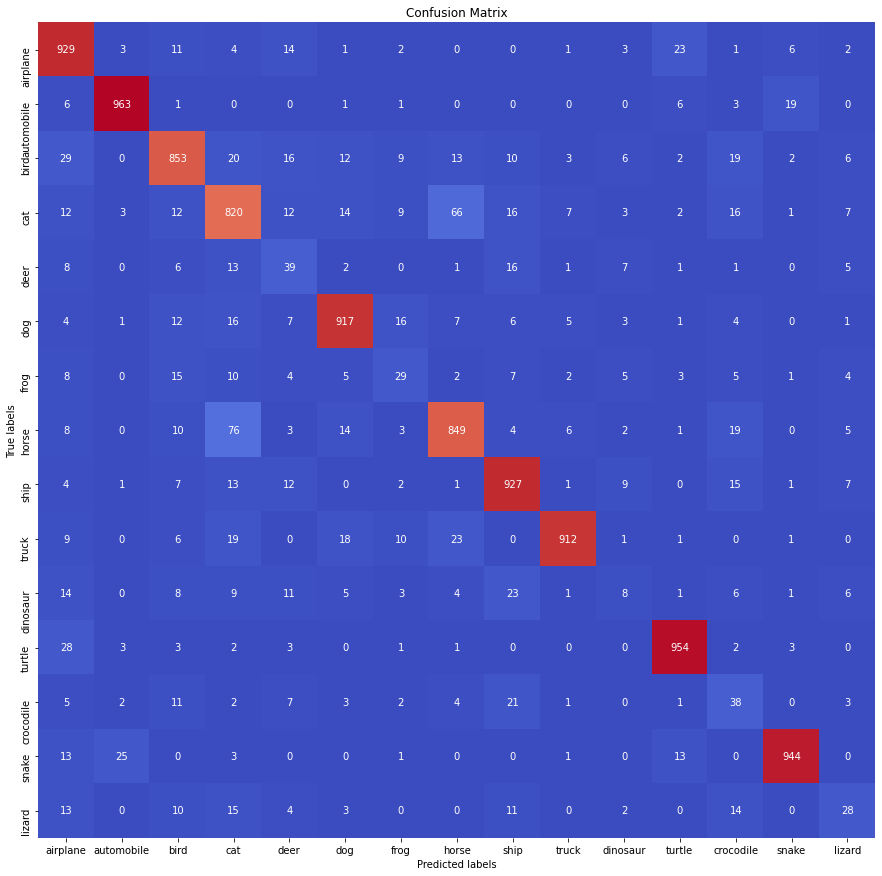

In [ ]:
cm = confusion_matrix(y_, a_)
print("Матрица ошибок для тестового множества:\n", cm)

plt.figure(figsize=(15, 15))
ax= plt.subplot()

sns.heatmap(cm, cbar=False, fmt='d', annot=True, cmap=plt.cm.coolwarm); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

In [ ]:
y_train_ = keras.utils.to_categorical(y_train15, 15)
y_test_ = keras.utils.to_categorical(y_test15, 15)
        

print("== DONE! ==\n== COLOR PREPROCESSING... ==")
    # color preprocessing
x_train_, x_test_ = color_preprocessing(x_train15, x_test15)


print("== DONE! ==\n== BUILD MODEL... ==")
    # build network
new_model.compile()
    
    # print model architecture if you need.
    # print(resnet.summary())
sgd = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
new_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# set callback
cbks = [TensorBoard(log_dir='./resnet_{:d}_{}/'.format(layers,'cifar100'), histogram_freq=0),
            LearningRateScheduler(scheduler)]
    
    # set data augmentation
print("== USING REAL-TIME DATA AUGMENTATION, START TRAIN... ==")
datagen = ImageDataGenerator(horizontal_flip=True,
                                 width_shift_range=0.125,
                                 height_shift_range=0.125,
                                 fill_mode='constant',cval=0.)
datagen.fit(x_train_)

    # start training
resnet50_model = new_model.fit_generator(datagen.flow(x_train_, y_train_,batch_size=batch_size),
                         steps_per_epoch=iterations,
                         epochs=20,
                         callbacks=cbks,
                         validation_data=(x_test_, y_test_))

== DONE! ==
== COLOR PREPROCESSING... ==
== DONE! ==
== BUILD MODEL... ==
== USING REAL-TIME DATA AUGMENTATION, START TRAIN... ==


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
391/391 [==============================] - 252s 638ms/step - loss: 0.2990 - accuracy: 0.9578 - val_loss: 0.6702 - val_accuracy: 0.8752
Epoch 2/20
391/391 [==============================] - 250s 640ms/step - loss: 0.3031 - accuracy: 0.9564 - val_loss: 0.6858 - val_accuracy: 0.8713
Epoch 3/20
391/391 [==============================] - 248s 635ms/step - loss: 0.3051 - accuracy: 0.9569 - val_loss: 0.6583 - val_accuracy: 0.8762
Epoch 4/20
391/391 [==============================] - 252s 644ms/step - loss: 0.3065 - accuracy: 0.9564 - val_loss: 0.6777 - val_accuracy: 0.8748
Epoch 5/20
391/391 [==============================] - 251s 643ms/step - loss: 0.3039 - accuracy: 0.9559 - val_loss: 0.6778 - val_accuracy: 0.8732
Epoch 6/20
391/391 [==============================] - 250s 640ms/step - loss: 0.3015 - accuracy: 0.9575 - val_loss: 0.6706 - val_accuracy: 0.8770
Epoch 7/20
391/391 [==============================] - 252s 644ms/step - loss: 0.3096 - accuracy: 0.9571 - val_loss: 0.6829 -

In [200]:
predictions_test = np.argmax(new_model.predict(x_test_), axis=1)
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
y =  np.argmax(y_test_, axis=1)
print('Accuracy для тестового множества:', metrics.accuracy_score(y, predictions_test))
print('Precision для тестового множества:', metrics.precision_score(y, predictions_test, average='macro'))
print('Recall для тестового множества:', metrics.recall_score(y, predictions_test, average='macro'))
print('F1-measure для тестового множества:', metrics.f1_score(y, predictions_test, average='macro'))

Accuracy для тестового множества: 0.8722857142857143
Precision для тестового множества: 0.6976071370400571
Recall для тестового множества: 0.7048
F1-measure для тестового множества: 0.6901050230531232


In [196]:
predictions_test = np.argmax(new_model.predict(x_train_), axis=1)
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
y =  np.argmax(y_train_, axis=1)
print('Accuracy для обучающего множества:', metrics.accuracy_score(y, predictions_test))
print('Precision для обучающего множества:', metrics.precision_score(y, predictions_test, average='macro'))
print('Recall для обучающего множества:', metrics.recall_score(y, predictions_test, average='macro'))
print('F1-measure для обучающего множества:', metrics.f1_score(y, predictions_test, average='macro'))

Accuracy для обучающего множества: 0.9502095238095238
Precision для обучающего множества: 0.7980169918042724
Recall для обучающего множества: 0.7707466666666666
F1-measure для обучающего множества: 0.7725732813175756


In [ ]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck',	'dinosaur', 'turtle', 'crocodile', 'snake', 'lizard']
y_ = [labels[i] for i in y]
a_ = [labels[i] for i in predictions_test]

Матрица ошибок для тестового множества:
 [[919   2  14   2   0   0   0   1  27   4   8   3  14   3   3]
 [  2 967   1   0   0   0   0   1   6  17   1   0   0   5   0]
 [ 24   0 868  12   9  13   8   3   2   2  24   1  14  18   2]
 [ 10   2  24 753  12  66  13  12   6   0  43   6  19  33   1]
 [  3   1  16  11 896   6   6   7   1   0  34   0  16   2   1]
 [  7   0  23  52  13 851   3   8   1   0  12   4   4  21   1]
 [  4   1  10   7   0   0 915   1   0   1   9   3  16  26   7]
 [  7   0   5   8  10  15   0 937   0   1  17   0   0   0   0]
 [ 24   3   3   0   0   1   0   1 960   1   1   0   3   3   0]
 [ 11  27   1   2   0   0   0   3  15 936   2   0   0   3   0]
 [  7   0  12   4   3   3   5   3   2   0  47   2   2   8   2]
 [ 13   0  15   8   2   0  11   0   1   0   7  20   7  14   2]
 [  7   0   9   7   2   1  13   1   2   0   3   4  43   2   6]
 [  5   2  11   2   3   4  18   1   1   0   5   3   5  39   1]
 [ 13   0   9   6   5   3  22   1   1   0   7   5  11   9   8]]


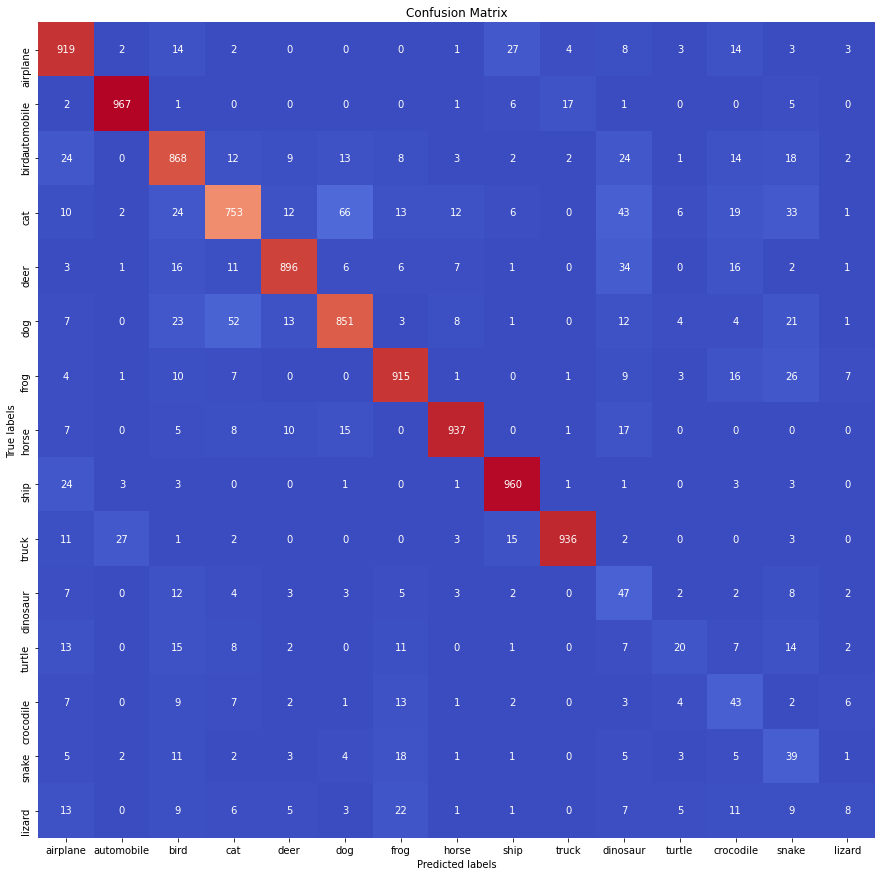

In [201]:
cm = confusion_matrix(y_, a_)
cm = confusion_matrix(y, predictions_test)
print("Матрица ошибок для тестового множества:\n", cm)

plt.figure(figsize=(15, 15))
ax= plt.subplot()

sns.heatmap(cm, cbar=False, fmt='d', annot=True, cmap=plt.cm.coolwarm); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

Матрица ошибок для обучающего множества:
 [[4963    1    3    0    0    0    0    1    8    0    4    3   10    1
     6]
 [   0 4991    0    0    0    0    0    0    0    3    0    0    0    6
     0]
 [   9    0 4911    1    1    2    2    0    0    0   21    7   17   24
     5]
 [   8    1   22 4655    1   34    3    1    1    1  128   19   41   80
     5]
 [   1    0    6    8 4868    5    5    4    0    0   65    2   28    6
     2]
 [   0    0   10   23    4 4884    2    8    0    0   14    4    3   43
     5]
 [   0    0    6    0    0    0 4834    0    1    0   19   22   29   71
    18]
 [   1    1    1    1    1    6    0 4956    0    0   31    0    0    2
     0]
 [  10    1    2    0    0    0    0    0 4982    1    0    0    2    2
     0]
 [   7   17    0    1    0    0    0    0    5 4962    4    0    0    4
     0]
 [  27    2   65   15   26   13   49   20    5    4  235    3   11   18
     7]
 [  32    5   89   21    8    5   89    1    5    0   26  124   41   49
     5

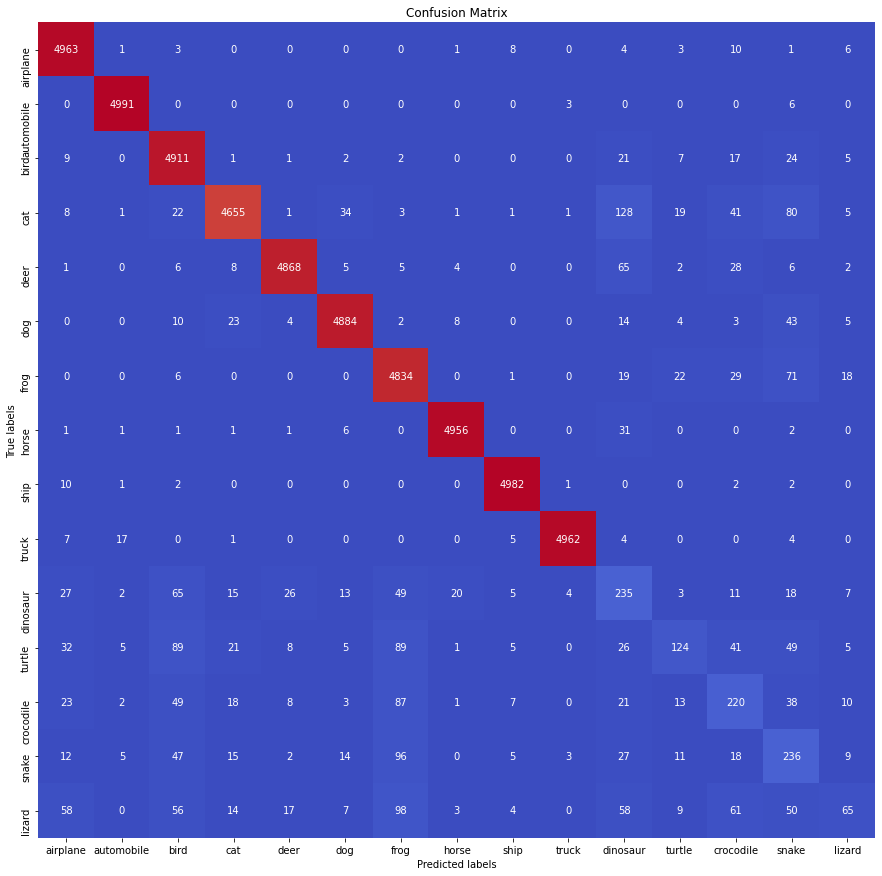

In [199]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck',	'dinosaur', 'turtle', 'crocodile', 'snake', 'lizard']
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck',	'dinosaur', 'turtle', 'crocodile', 'snake', 'lizard']
y_ = [labels[i] for i in y]
a_ = [labels[i] for i in predictions_test]
cm = confusion_matrix(y_, a_)
cm = confusion_matrix(y, predictions_test)
print("Матрица ошибок для обучающего множества:\n", cm)

plt.figure(figsize=(15, 15))
ax= plt.subplot()

sns.heatmap(cm, cbar=False, fmt='d', annot=True, cmap=plt.cm.coolwarm); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);